In [11]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening


import pickle

In [12]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [13]:
TIC = 'TIC 420779000' #HAT-P-26b / TIC 420779000

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))

lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 420779000" SECTOR=50 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [14]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2665.276621666103,1.0008752e+00,1.6877042e-03,5.0983941e-03,1035228,1712.50806,1864.32177,6.1302373e+03,1.0319491e+01,1.5157616e+03,3.7660410e+00,7.1721631e+03,1.2093904e+01,0,———,———,———,———,1712.50806,1.3248915e-03,1864.32177,1.3110075e-03,-3.7879929e-02,1.0244901e-01
2665.2780106009227,9.9939626e-01,1.6885798e-03,5.0984407e-03,1035229,1712.51308,1864.32094,6.1227061e+03,1.0324845e+01,1.5224823e+03,3.7810454e+00,7.1615649e+03,1.2100179e+01,0,———,———,———,———,1712.51308,1.3261628e-03,1864.32094,1.3112831e-03,-3.2004643e-02,1.0131135e-01
2665.2793995357433,9.9927253e-01,1.6881203e-03,5.0984873e-03,1035230,1712.51125,1864.31516,6.1217334e+03,1.0322036e+01,1.5206570e+03,3.7757792e+00,7.1606782e+03,1.2096887e+01,0,———,———,———,———,1712.51125,1.3261768e-03,1864.31516,1.3103712e-03,-3.7128687e-02,9.5918149e-02
2665.2807884705635,1.0043720e+00,1.6912979e-03,5.0985338e-03,1035231,1712.50948,1864.32062,6.1531748e+03,1.0341465e+01,1.5216674e+03,3.7705452e+00,7.1972202e+03,1.2119657e+01,0,———,———,———,———,1712.50948,1.3216167e-03,1864.32062,1.3083346e-03,-3.4576565e-02,1.0225669e-01
2665.2821774058493,1.0007608e+00,1.6884294e-03,5.0985808e-03,1035232,1712.50742,1864.31755,6.1306606e+03,1.0323926e+01,1.5226661e+03,3.7688382e+00,7.1713428e+03,1.2099101e+01,0,———,———,———,———,1712.50742,1.3256199e-03,1864.31755,1.3087012e-03,-3.8559388e-02,1.0009597e-01
2665.2835663406704,9.9956930e-01,1.6884031e-03,5.0986274e-03,1035233,1712.51242,1864.31983,6.1226650e+03,1.0323764e+01,1.5179741e+03,3.7734630e+00,7.1628047e+03,1.2098912e+01,0,———,———,———,———,1712.51242,1.3269043e-03,1864.31983,1.3105640e-03,-3.4752984e-02,1.0057126e-01
2665.2849552754915,9.9820203e-01,1.6865281e-03,5.0986740e-03,1035234,1712.50889,1864.31878,6.1138428e+03,1.0312301e+01,1.5209933e+03,3.7675910e+00,7.1530068e+03,1.2085477e+01,0,———,———,———,———,1712.50889,1.3263194e-03,1864.31878,1.3127550e-03,-3.9159257e-02,1.0016379e-01
2665.2863442103117,9.9677658e-01,1.6860449e-03,5.0987205e-03,1035235,1712.51207,1864.32187,6.1045146e+03,1.0309346e+01,1.5252603e+03,3.7711377e+00,7.1427925e+03,1.2082014e+01,0,———,———,———,———,1712.51207,1.3281615e-03,1864.32187,1.3129751e-03,-3.5147920e-02,1.0174066e-01


In [15]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

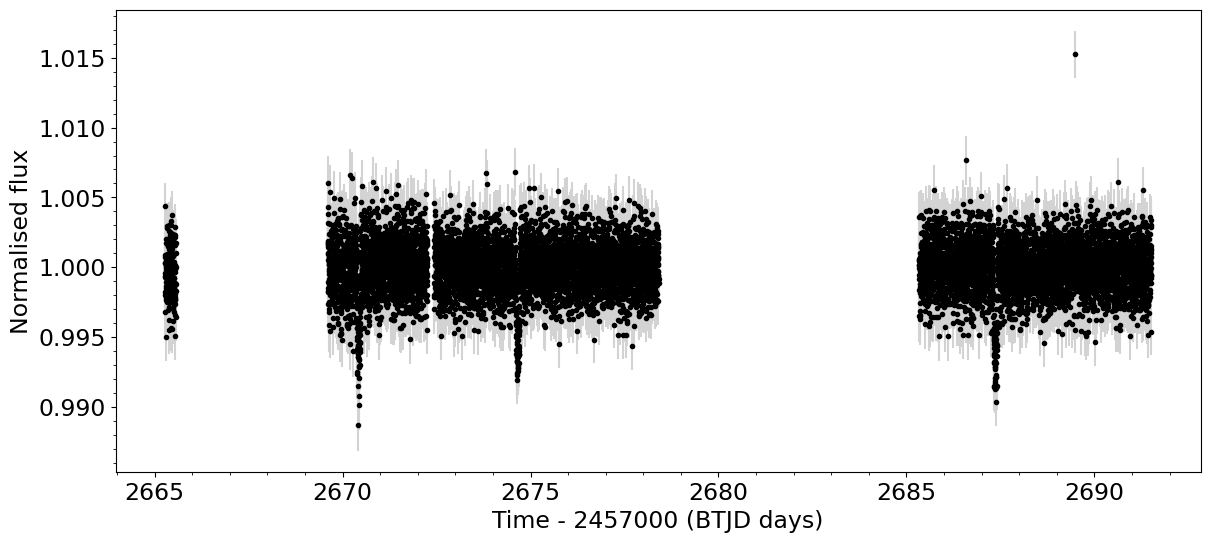

In [18]:
fig, ax = plt.subplots(1, figsize=(14,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [ ]:
ld_data_path = r"\Users\Student\Documents\exotic_ld_data"

ld_model = 'mps1' # Stellar models grid.

M_H = 0.01 # Metallicty [dex].
#Mortier et al. 2013

Teff = 5011 # Effective temperature [K].
#Mortier et al. 2013

logg = 4.56 # Surface gravity [dex].
#Hartman et al. 2010

sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)

# Start and end of wavelength interval [angstroms].
wavelength_range = [6000., 10000.]

# Instrument mode.
mode = 'TESS'

u1, u2 = sld.compute_quadratic_ld_coeffs(wavelength_range, mode)

In [ ]:
prior_Rs = 0.8564404 #R_sun, Gaia DR2

guess_params = batman.TransitParams()
guess_params.ecc = 0.124 #Hartman et al. 2010
guess_params.w = 46.0                                          #Knutson et al. 2014 - longitude of periastron (in degrees)
guess_params.limb_dark = "quadratic"                          #limb darkening model
guess_params.u = [u1, u2]                             #limb darkening coefficients


In [ ]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    guess_params.t0 = t_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)

    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    t_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    P = 0.0
    if (t_0 < 2670.0) or (t_0 > 2671): #Days
        P += -np.inf
        return -np.inf

    if (R_planet_stellar < 0.05) or (R_planet_stellar > 0.1):
        P += -np.inf
        return P

    if (orbital_period < 4.23448) or (orbital_period > 4.23454): #Days
        P += -np.inf
        return P

    if (orbital_inclination < 81) or (orbital_inclination > 90): #Degrees
        P += -np.inf
        return -np.inf
    

    if (semi_major_axis < 5) or (semi_major_axis > 20): #AU
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [ ]:
prior_t0 = 2670.4 #(Days) Myself
prior_rprs = 0.0737 #Hartman et al. 2010
prior_per = 4.2345026 #(Days) Ivshina & Winn 2022
prior_inc = 88.6 #(Deg) Hartman et al. 2010
prior_a = semi_major_axis_in_stellar_radii(0.0479, prior_Rs) #(AU) Hartman et al. 2010

guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]

In [ ]:
scatter = 1E-8 #Walker scattering of the parameters

pos = guess + scatter * np.random.randn(20, len(guess))

nwalkers, ndim = pos.shape

filename = "HAT_P_26b.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux_data, yerrs), a=2)
    sampler.run_mcmc(pos, 15000, progress=True)
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

In [ ]:
fig, axes = plt.subplots(len(guess), figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]
labels = [r"$T_{0}$ (Days)", r"$R_{p}/R_{*}$", "Orbital Period (Days)", "Orbital Inclination (Deg)", "Semi-major axis (a/Rs)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples.shape)

In [ ]:
filename = "HAT_P_26b_flat_samples.p"
file = open(filename, "wb")
pickle.dump(flat_samples, file)
file.close()

In [ ]:
fig = corner.corner(
    flat_samples, labels=labels)